In [1]:
import numpy as np
import cv2

<h1 style = "text-align: center">
    <a href = "https://docs.opencv.org/4.5.3/d8/dfe/classcv_1_1VideoCapture.html">VideoCapture</a>
</h1>
<h2 style = "text-align: center">
is class for video capturing from video files, image sequences or cameras.
</h2>

In [2]:
cap = cv2.VideoCapture(0) # 0 is a id-number of video devices

while cap.isOpened() :
    #Read new frame
    ret, frame = cap.read()
    if ret == True :
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(33) & 0xFF == ord('q') : # Period control f - 1/T
            break
    else :
        break
    
cap.release()
cv2.destroyAllWindows()

In [3]:
vid = cv2.VideoCapture('./videos/Ant Tracking Hard.mp4')

while vid.isOpened() :
    ret, frame = vid.read()
    
    if ret :
        cv2.imshow('Video frame', frame)

        if cv2.waitKey(int(1000/24)) & 0xFF == ord('q') : # this line control the period between image frame
            break
    else :
        break
vid.release()
cv2.destroyAllWindows()

<h1 style="text-align: center">
    Lucus-Kanade Sparse Optical Flow 
</h1> <br>
<h2 style="text-align: left">
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323"> calcOpticalFlowPyrLK()</a>
    is a Lucas-Kanade Spares Optical Flow built-in OpenCV function inside 
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html"> Object Tracking </a>
    module.
</h2>

In [5]:
def lucas_kanade_optical_flow(video_device) :

    cap = cv2.VideoCapture(video_device)
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
                        qualityLevel = 0.03,
                        minDistance = 7,
                        blockSize = 25 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (21,21),
                    maxLevel = 3,
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    #Create some random colors
    colors = np.random.randint(0, 255, (500, 3)) # 500 values 3 channel

    #Take first frame and find corner
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params) # Feature detection, Harris corner with Shi-Tomasi response function

    # Create a mask image for drawing overlay
    mask = np.zeros_like(old_frame)

    while cap.isOpened() :
        
        ret, frame = cap.read()

        if ret :
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            #calculate optical flow 
            p1, st, err = cv2.calcOpticalFlowPyrLK(
                old_gray, frame_gray, p0, None, **lk_params
            )

            # Select good points
            good_new = p1[st == 1]
            good_old = p0[st == 1]

            # Traceline drawing
            for i, (new, old) in enumerate(zip(good_new, good_old)):
                a, b = new.ravel().astype(int)
                c, d = old.ravel().astype(int)
                mask = cv2.line(mask, (a, b), (c, d), colors[i].tolist(), 2)
                frame = cv2.circle(frame, (a,b), 5, colors[i].tolist(), -1)
            
            compare_img = cv2.hconcat([frame, mask])
            disp_img = cv2.add(frame, mask)
            cv2.imshow('compare', compare_img)
            cv2.imshow('frame', disp_img)

            key = cv2.waitKey(27) & 0xFF
            if key == 27 or key == ord('q') :
                break
            elif key == ord('c') : # clear mask
                mask = np.zeros_like(old_frame)
                p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
            else :
                #Update the previous frame and previous points
                old_gray = frame_gray.copy()
                p0 = good_new.reshape(-1, 1, 2)
        else :
            break

    cap.release()
    cv2.destroyAllWindows()

lucas_kanade_optical_flow(0)

<h1 style="text-align: center">
    Farnebäck Optical Flow
</h1> <br>
<h2 style="text-align: left">
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af"> calcOpticalFlowFarneback()</a>
    is a Farnebäck Dense Optical Flow built-in OpenCV function inside 
    <a href="https://docs.opencv.org/4.5.3/dc/d6b/group__video__track.html"> Object Tracking </a>
    module. <br>
    <a href="https://docs.opencv.org/4.5.3/d2/de8/group__core__array.html#gac5f92f48ec32cacf5275969c33ee837d">cartToPolar() </a>
    is a utility function for cartesian to polar conversion
</h2>

In [10]:
def farneback_dense_optical_flow(video_device) :
    cap = cv2.VideoCapture(video_device)

    ret, frame = cap.read()
    last_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame)
    hsv[:, :, 1] = 255

    while cap.isOpened() :
        ret, frame = cap.read()

        if ret :
            
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            flow = cv2.calcOpticalFlowFarneback(last_frame, frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) # flow dx dy
            
            mag, ang = cv2.cartToPolar(flow[:, :, 0], flow[:, :, 1])
            hsv[:, :, 0] = ang*(180/np.pi/2)
            hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

            flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            # thresh = cv2.inRange(hsv,(0, 0, 30), (20,255,255))
            # motion_segment = cv2.bitwise_and(frame, frame, mask=thresh )
            # cv2.imshow('thresh', motion_segment)
           
            last_frame = frame_gray.copy()

            cv2.imshow('frame', frame)
            cv2.imshow('flow', flow_rgb)
            key = cv2.waitKey(27) & 0xFF
            if key == 27 or key == ord('q') :
                break

        else :
            break
    
    cap.release()
    cv2.destroyAllWindows()
            

farneback_dense_optical_flow('./videos/Flow Visualization.mp4')

<h1 style="text-align: center">
    Optical Flow exercise
</h1>

<h2>แบบฝึกหัดที่ 10</h2>
<h4>วัตถุประสงค์ </h1>

- ทักษะการประยุกต์ใช้เทคนิค optical flow
<h4>โจทย์</h4>

- ให้นักศึกษาเขียน code ซอฟต์แวร์นำข้อมูลวิดีโอมาประมวลผลเพื่อติดตามการเคลื่อนไหวของคนหรือสิ่งของภายในภาพ (Crowd heatmapping)
- ให้นักศึกษากำหนด ROI (พื้นที่ที่สนใจของภาพ, พื้นที่ในกรอบสี่เหลี่ยมของภาพ) เพื่อป้องกันการตรวจจับเสาและสภาพแวดล้อมที่ไม่เกี่ยวข้องภายนอก
- ในการส่งงานให้นักศึกษาคอมเมนต์ code ที่ตนเองเขียนและอัพโหลดไปยัง github ของตนเองแล้วนำลิงก์ดังกล่าวไปโพสต์ส่งใน googleclassroom
- video ต่าง ๆ ที่ถูกในในตัวอย่างด้านบนอยู่ภายใน directory <a href="https://github.com/jbinteam/010723305/tree/main/videos">videos</a>
- ชุดข้อมูลวิดีโอ <a href = "https://github.com/jbinteam/010723305/blob/main/videos/grandcentral.mp4?raw=true">grandcentral.mp4</a><br>
- ผลลัพธ์ที่คาดหวัง <a href ="https://youtu.be/UoXAaafHeQY" >Youtube Video</a> 


In [ ]:
!pip install matplotlib

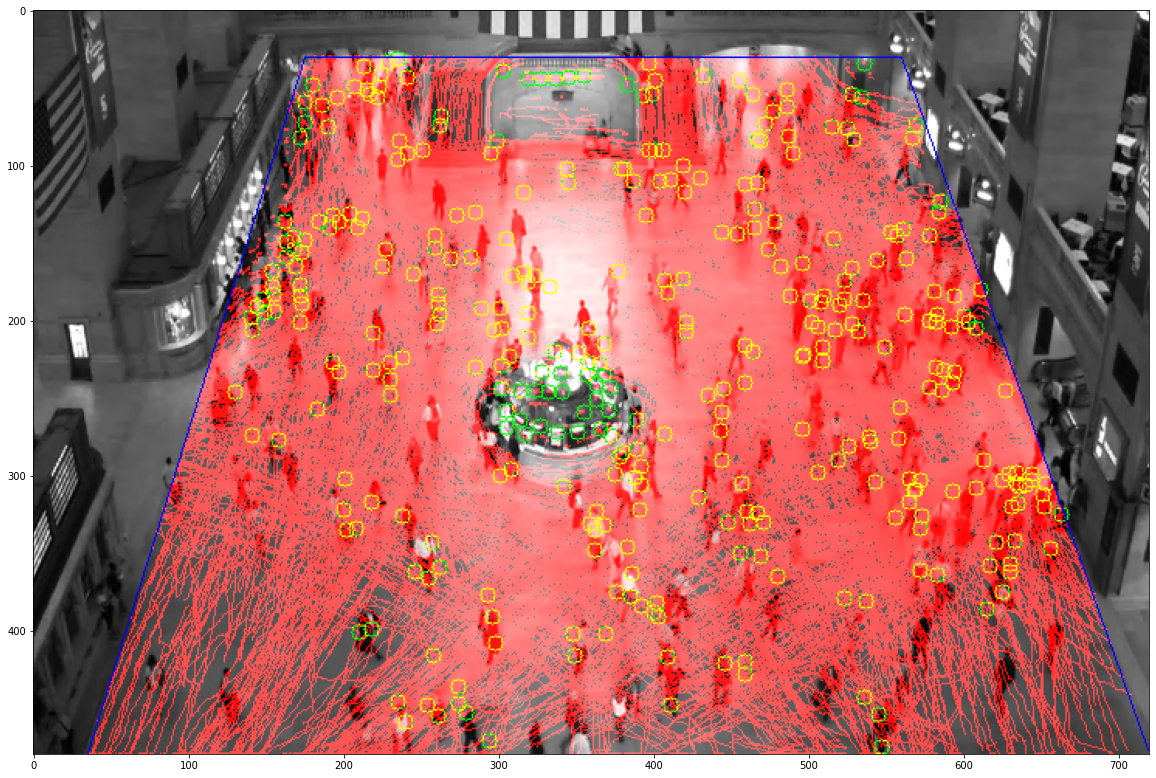

In [19]:
import matplotlib.pylab as plt                                  #เรียกใช้งานไลบรารี่ matplotlib

cap = cv2.VideoCapture('./videos/grandcentral.mp4')             #เรียกใช้งานวิดีโอ grandcentral.mp4 ในโฟลเดอร์ videos ใช้ชื่อว่า cap

feature_params = dict(maxCorners = 500,                         #ใช้งาน dictionary เก็บค่าพารามิเตอร์ต่างๆ โดยเก็บค่าคอนเนอร์สูงสุด 500 ตัว 
                    qualityLevel = 0.03,                        #ค่าคุณภาพอยู่ที่ 0.03
                    minDistance = 7,                            #ค่าระยะห่างน้อยสุดอยู่ที่ 7 px
                    blockSize = 25)                             #ขนาดบล็อกในการคำนวณอยู่ที่ 25 บล็อก

lk_params = dict(winSize = (21,21),                             #ใช้งาน dictionary เก็บค่าพารามิเตอร์ต่างๆ โดยเก็บค่าขนาดวินโดร์ 21x21
                maxLevel = 3,                                   #ค่าเลเวลเท่ากับ 3
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)) #ค่าที่ใช้ในการหยุดการทำงานอยู่ที่ 10 กับ 0.03

ret, old_frame = cap.read()                                     #ทำการอ่านค่าวิดีโอจาก cap ออกมาเป็น ret และ frame

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)                  #ทำการเปลี่ยนโมเดลสีของภาพจาก BGR เป็น Grayscale
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)     #ทำการตรวจจับฟีเจอร์ด้วยฟังก์ชัน Shi-Tomasi response

mask = np.zeros_like(old_frame)                                 #ทำการสร้าง mask ที่มีค่า 0 ที่มึขนาดเท่ากับ old_frame

pts = np.array([[175,30], [35,480], [720,480], [560,30]],np.int32)      #ทำการสร้างอาร์เรย์เก็บค่าตำแหน่งจุด 4 จุด เพื่อสร้างพื้นที่ที่สนใจ (roi)
roi = np.zeros(old_frame.shape[:2], np.uint8)                           #ทำการสร้าง roi ที่มีค่า 0 ที่มึขนาดเท่ากับ old_frame ที่ตำแหน่ง 0 ถึง 1
cv2.drawContours(roi, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)      #ทำการวาด contour ลงบน roi ตามตำแหน่งจุดในอาร์เรย์ pts

while cap.isOpened() :                                          #เมื่อวิดีโอ cap ทำงานอยู่ก็จะทำงานต่อไปเรื่อยๆ
    ret, frame = cap.read()                                     #ทำการอ่านค่าวิดีโอจาก cap ออกมาเป็น ret และ frame

    if ret :                                                    #ทำการตรวจสอบภาพที่อ่าน ถ้า ret มีค่าเป็น true
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    #ทำการเปลี่ยนโมเดลสีของภาพจาก BGR เป็น Grayscale   

        p1, st, err = cv2.calcOpticalFlowPyrLK(                 #ทำการคำนวณค่า optical flow โดยให้ค่าออกมาเป็นตำแหน่งปัจจุบัน สเตตัส และค่าผิดพลาด
            old_gray, frame_gray, p0, None, **lk_params         #โดยใส่ค่าภาพก่อนหน้า ภาพปัจจุบัน ตำแหน่งก่อนหน้า และค่าพารามิเตอร์ใน lk_params
        )
    
        good_new = p1[st == 1]                                  #ทำการเลือกตำแหน่ง p1 ที่มีค่าสถานะเป็น 1 เพื่อให้ได้ตำแหน่งปัจจุบันที่มีสถานะที่ดี
        good_old = p0[st == 1]                                  #ทำการเลือกตำแหน่ง p0 ที่มีค่าสถานะเป็น 1 เพื่อให้ได้ตำแหน่งก่อนหน้าที่มีสถานะที่ดี
        
        for i, (new, old) in enumerate(zip(good_new, good_old)):    #ทำการวนลูปตามจำนวนของ good_new รวมกับ good_old
            a, b = new.ravel().astype(int)                          #ทำการเก็บค่าตำแหน่ง a,b ของตำแหน่งปัจจุบัน
            c, d = old.ravel().astype(int)                          #ทำการเก็บค่าตำแหน่ง c,d ของตำแหน่งก่อนหน้า
            a = a if a < roi.shape[1] else roi.shape[1]-1           #ทำการตรวจสอบค่า a ไม่ให้ค่าของ a มีค่ามากกว่า 720
            b = b if b < roi.shape[0] else roi.shape[0]-1           #ทำการตรวจสอบค่า a ไม่ให้ค่าของ a มีค่ามากกว่า 480
            if roi[b,a] == 255:                                     #ทำการตรวจสอบค่าในตำแหน่ง a,b ว่าอยู่ในพื้นที่ roi หรือไม่
                mask = cv2.line(mask, (a,b), (c,d), (0,0,255), 1)   #ถ้าอยู่ในพื้นที่ roi จะทำการวาดเส้นสีแดงจากตำแหน่งก่อนหน้าถึงตำแหน่งปัจจุบันลงบน mask
                frame = cv2.circle(frame, (a,b), 5, (0,255,0), 1)   #ทำการวาดเส้นวงกลมสีเขียวบนตำแหน่งปัจจุบันโดยมีรัศมี 5 px ลงบน frame

        disp_img = cv2.add(frame, mask)                         #นำภาพ frame กับ mask มารวมกันเป็น disp_img
        cv2.polylines(disp_img, [pts], True, (255,0,0), 1)      #ทำการวาดเส้นสีน้ำเงินตามตำแหน่งจุดในอาร์เรย์ pts เพื่อสร้างเป็นพื้นที่ที่สนใจลงบน disp_img
        cv2.imshow('frame', disp_img)                           #ทำการแสดงภาพ disp_img

        key = cv2.waitKey(33) & 0xFF                            #ทำการอ่านค่า waitKey เท่ากับ 33
        if key == 27 or key == ord('q'):                        #ทำการตรวจสอบการกดปุ่ม esc หรือปุ่ม q
            img = disp_img[0:480, 0:720]                        #เมื่อทำการกดปุ่ม esc หรือปุ่ม q จะทำการตัดภาพเฟรมสุดท้าย
            break                                               #และทำการออก
        elif len(good_new) < 480:                               #ทำการตรวจสอบจำนวนของ good_new เมื่อมีค่าน้อยกว่า 480
            p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params) #จะทำการตรวจจับฟีเจอร์ใหม่
        else:                                                   #ถ้าไม่มีการกดปุ่ม
            old_gray = frame_gray.copy()                        #ทำการอัพเดทภาพปัจจุบันให้กลายเป็นภาพก่อนหน้า
            p0 = good_new.reshape(-1,1,2)                       #ทำการอัพเดทค่าตำแหน่ง good_new ให้กลายเป็นค่าตำแหน่งก่อนหน้า
    else:                                                       #ถ้า ret มีค่าเป็น false
        img = disp_img[0:480, 0:720]                            #ทำการตัดภาพเฟรมสุดท้าย
        break                                                   #และทำการออก

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                      #ทำการเปลี่ยนโมเดลสีของภาพจาก BGR เป็น Grayscale 
plt.figure(figsize=(20,20))                                     #ทำการกำหนดขนาดภาพที่จะแสดงบน matplotlib
plt.imshow(img)                                                 #ทำการแสดงภาพเฟรมสุดท้ายด้วย matplotlib

cap.release()                                                   #ทำการคืนค่า
cv2.destroyAllWindows()                                         #ทำการปิดหน้าจอการทำงานทั้งหมด

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#                                                                       _oo0oo_                                                                       #
#                                                                      o8888888o                                                                      #
#                                                                      88" . "88                                                                      #
#                                                                      (| -_- |)                                                                      #
#                                                                      0\  =  /0                                                                      #
#                                                                    ___/`---'\___                                                                    #
#                                                                  .' \|     |// '.                                                                   #
#                                                                 / \|||  :  |||// \                                                                  #
#                                                                / _||||| -:- |||||- \                                                                #
#                                                               |   | \\  -  /// |   |                                                                #
#                                                               | \_|  ''\---/''  |_/ |                                                               #
#                                                               \  .-\__  '-'  ___/-. /                                                               #
#                                                             ___'. .'  /--.--\  `. .'___                                                             #
#                                                          ."" '<  `.___\_<|>_/___.' >' "".                                                           #
#                                                         | | :  `- \`.;`\ _ /`;.`/ - ` : | |                                                         #
#                                                         \  \ `_.   \_ __\ /__ _/   .-` /  /                                                         #
# =========================================================`-.____`.___ \_____/___.-`___.-'========================================================== #
#                                                                       `=---='                                                                       #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 